# Bridging Language Barriers Through Contextual LLM 

This Jupyter notebook demonstrates the usage of Gemini 1.5’s long-context capability for low-resource language translation and sign language interpretation. The project explores the capability of large language models to work with contextual learning for languages with limited training data.

## Dataset Link
Associated dataset can be found at: https://www.kaggle.com/datasets/rajahaseeb/kalasha-asl-dataset

## Project Overview

1. English to Kalasha language translation using contextual learning
2. English to American Sign Language (ASL) instruction generation

Initially, I only intended to work on the first task. However, I suddenly had the urge to extend it to sign language as well.

## Impact

This project represents a significant advancement in language technology by addressing two critical areas: preservation of endangered languages and accessibility of sign language instruction. By leveraging Google's Gemini Pro model with contextual learning capabilities, it demonstrates a practical approach to working with low-resource languages like Kalasha and providing structured American Sign Language (ASL) instructions. This technical innovation has immediate applications in language preservation, education, and cross-cultural communication.

The project's impact extends beyond its technical achievements, offering a scalable framework for language documentation and instruction that could benefit indigenous communities, sign language users, educators, and researchers. By making language resources more accessible and providing tools for documentation and learning, it contributes to the broader goals of linguistic diversity preservation and digital inclusion, while establishing a foundation for future developments in language technology.

## Setup and installation

In this section, we will install the required packages and and set up our generation api.

In [1]:
# Install dependencies
# !pip install google-generativeai

In [2]:
# Set up gemini api
import google.generativeai as genai

api_key="xxx"
genai.configure(api_key=api_key)

## Task-1: Translating English text to Kalasha

### The Kalasha Language

The Kalasha language (also known as Kalashamon) is a remarkable Dardic language spoken by the Kalash people, an indigenous community residing in the remote valleys of Pakistan's Hindu Kush mountains, primarily in the Chitral region. As one of the last remaining representations of pre-Islamic culture in the area, Kalasha holds unique linguistic and cultural significance, with estimates suggesting fewer than 5,000 active speakers remain. The language, which belongs to the Indo-Aryan branch of Indo-European languages, has remained relatively isolated due to the geographical remoteness of its speakers, helping preserve distinct features of its grammar and vocabulary. However, this isolation, combined with increasing modernization and the influence of more dominant regional languages, has also placed Kalasha on UNESCO's list of endangered languages, making its documentation and preservation particularly crucial for linguistic diversity and cultural heritage.

### Dataset
It was difficult to find much details on Kalasha language online. I grabbed a couple of open resources
and used them as context.

#### Context documents
Kalasha Texts with Introductory Grammar: https://www.tandfonline.com/doi/pdf/10.1080/03740463.2015.1069049
Kalasha Dictionary by National Institute of Pakistan Studies: https://ia601702.us.archive.org/25/items/kalasha-dictionary/Kalasha-dictionary.pdf

#### Example sentences
Example sentences used in prompts are taken from this [dictionary](https://www.indigenouspeople.net/Kalashdictionary.pdf) which is available online for free. This source is not included in the context.

## Testing original model

First of all, let's see if our original model can perform the task at hand. We will be using `Gemini-1.5-Pro` model for this task.

In [3]:
# Load the model
model_name = 'models/gemini-1.5-pro-001'
model = genai.GenerativeModel(model_name=model_name)

In [4]:
# Some test sentences
test_sentences = """
    Sentence 1: "The weather is so nice today. I want to take a walk!",
    Sentence 2: "How are you feeling today?"
"""

# Design the prompt
prompt = (
    f'Translate the following text to Kalasha language: {test_sentences}'
    'Just write original sentence and translation, nothing else.'
    
    'Use the following structure:'
    
    'English Sentence: {Write english sentence here}'
    
    'Kalasha Sentence: {Write output translation here}'
)

    

In [5]:
from IPython.display import display, Markdown

# Generate reponse
response = model.generate_content(prompt)
display(Markdown(response.text))

Unfortunately, I can't provide translations in the Kalasha language. There are very limited resources available for this language, and I am not equipped to generate accurate translations for it. 

Providing inaccurate translations for a language with so few speakers could be detrimental and contribute to its further endangerment. 

I recommend seeking out a language expert or contacting organizations dedicated to preserving the Kalasha language for assistance with translation. 


As suspected, since out model is not trained on Kalasha language, it is unable to provide translations.

## Adding context and utilizing long-context window

Now let's make use of our long-context window and add some context documents so that our model can utilize them during the generation process. We will also make use of context caching to minimize cost. This is useful especially when we want to have multiple queries over a period of time.

### Add context and create a cache

In [6]:
from google.generativeai import caching
import datetime

document1 = genai.upload_file(path="./kalasha_texts_with_introductory_grammar.pdf")
document2 = genai.upload_file(path="./kalasha-dictionary.pdf")

# Create a cache
cache = caching.CachedContent.create(
    model=model_name,
    display_name='Kalasha Texts Manual', # used to identify the cache
    system_instruction=(
        'You are an expert in English-Kalasha translation. Translate the English text '
        'provided by the user to Kalasha language based on the document' 
        'that you have access to.'
    ),
    contents=[document1, document2],
    ttl=datetime.timedelta(minutes=60),
)

In [7]:
print(cache)

CachedContent(
    name='cachedContents/9z44m94ldaxj',
    model='models/gemini-1.5-pro-001',
    display_name='Kalasha Texts Manual',
    usage_metadata={
        'total_token_count': 883566,
    },
    create_time=2024-11-29 12:09:54.636255+00:00,
    update_time=2024-11-29 12:09:54.636255+00:00,
    expire_time=2024-11-29 13:09:53.678792+00:00
)


As shown above, we have a total of `883566` tokens in our cache.

### Generate using the context cache and verify
Let's utilize our cache to generate the translations.

In [8]:
# Construct a GenerativeModel which uses the created cache.
model = genai.GenerativeModel.from_cached_content(cached_content=cache)

In [9]:
response = model.generate_content(prompt)
display(Markdown(response.text))

English Sentence: The weather is so nice today. I want to take a walk!
Kalasha Sentence: Ájoa musim bo pruśt́híu. Tsakér kar-ím par-ím!

English Sentence: How are you feeling today?
Kalasha Sentence: Tu ájoa khéhá as-as? 


To my surprise, the model performed better than expected. There are some words which are translated corrected like:

- weather -> musim
- prust -> good
- kheha -> how (are you)
- Tu -> you
- ajo -> today

Of course it is far from perfect. There are some out of context words and symbolic issues for sure, and the sentence structure is incorrect. However, this is a good place to start!

Another rough verification could be to translate the text back to English.

### Translating text back to English

In [10]:
test_sentences = """
    Sentence 1: Ájoa musim bo pruśt́híu. Tsakér kar-ím par-ím!
    Sentence 2: Tu ájoa khéhá as-as?
"""

# Design the prompt
prompt = (
    f'Translate the following text to Kalasha language: {test_sentences}'
    'Just write original sentence and translation, nothing else.'
    
    'Use the following structure:'
    
    'Kalasha Sentence: {Write Kalasha sentence here}\n'
    'English Sentence: {Write output translation here}\n'
)

response = model.generate_content(prompt)
display(Markdown(response.text))

Kalasha Sentence: **Ájoa musim bo pruśt́híu. Tsakér kar-ím par-ím!**
English Sentence: *The weather is very nice now. Let’s go for a walk!*

Kalasha Sentence: **Tu ájoa khéhá as-as?**
English Sentence: *How are you today?* 


The model could be cheating when we translate the text back. However, if we notice, the english sentences are not exactly the same as the original sentences, which is a good sign.

Original sentences:
- The weather is so nice today. I want to take a walk! 
- How are you feeling today?

## Task 2: Extending task 1 to American Sign Language (ASL)
Now we will focus on ASL. I found a manual online at this [link](https://cdn.preterhuman.net/texts/thought_and_writing/language/The%20Complete%20Idiot's%20Guide%20to%20Learning%20American%20Sign%20Language.pdf). We will test the model with and without it. I will be using `Gemini-1.5-Flash` model for this task to utilize the free-tier.

### Clear cache
Let's clean the cache first and reload the model.

In [ ]:
# Clean cache
cache.delete()
for c in caching.CachedContent.list():
  print(c)

### Load the model

In [15]:
# Load the model
model_name = 'models/gemini-1.5-flash-001'
model = genai.GenerativeModel(model_name=model_name)

### Testing original model's knowledge of ASL

In [ ]:
response = model.generate_content(
    'How can I wish someone happy birthday in american sign language?'
    'Just write the method in simple points.'
    )
display(Markdown(response.text))

Here's how to sign "Happy Birthday" in American Sign Language:

1. **"Happy"**: Sign "HAPPY" by making a "H" handshape (thumb and pinky extended, other fingers closed) and moving it from your chin upward in a slight arc.
2. **"Birthday"**: Sign "BIRTHDAY" by making a "B" handshape (thumb and index finger extended, other fingers closed) and moving it from your forehead down in a slight arc. 
3. **Combine**:  Sign "HAPPY" and then "BIRTHDAY" smoothly together.

**Bonus:** You can add a sign for the person's name before or after the birthday greeting.


In [ ]:
response = model.generate_content(
    'How can I say "white color" in american sign language?'
    'Just write the method in simple points.'
    )
display(Markdown(response.text))

Here's how to sign "white color" in American Sign Language (ASL):

1. **Sign "color"**:  Make a "C" handshape (index finger and thumb extended, other fingers curled) and move it in a small circle in front of your chest.
2. **Sign "white"**:  Make a "W" handshape (index and middle fingers extended, other fingers closed) and touch your chin with your index finger, then move it out and down to your side.

**Together, the signs "color" then "white" represent "white color".** 


As we can see, the model does output some instructions, but they are not accurate at all.

### Providing context

Let's add the ASL Manual as context for the model and test again.

In [16]:
from google.generativeai import caching
import datetime

document = genai.upload_file(path="the_complete_idiots_guide_to_learning_american_sign_language.pdf")

# Create a cache for the context
cache = caching.CachedContent.create(
    model=model_name,
    display_name='ASL Manual', # used to identify the cache
    system_instruction=(
        'You are an expert in american sign language, and your job is to complete '
        'the user\'s request and provide appropriate answer based on the document' 
        'that you have access to.'
    ),
    contents=[document],
    ttl=datetime.timedelta(minutes=60),
)

for c in caching.CachedContent.list():
  print(c)


CachedContent(
    name='cachedContents/6bv7986ts5e7',
    model='models/gemini-1.5-flash-001',
    display_name='ASL Manual',
    usage_metadata={
        'total_token_count': 252123,
    },
    create_time=2024-11-29 12:21:40.175647+00:00,
    update_time=2024-11-29 12:21:40.175647+00:00,
    expire_time=2024-11-29 13:21:38.704776+00:00
)


In [17]:
# Construct a GenerativeModel which uses the created cache.
model = genai.GenerativeModel.from_cached_content(cached_content=cache)

In [ ]:
response = model.generate_content(
    'How can I wish someone happy birthday in american sign language?'
    'Explain concisely in step-by-step fashion. Add all the steps here.'
    'Do not point to any references.'
    )
display(Markdown(response.text))

1.  Make the sign for “happy,” holding your right hand to your chest with the palm facing toward you,  and move it up and down two times. 
2.  Bring your right hand down to rest on your left palm. 
3. Make the sign for “day” (see Chapter 19.) This combines the signs for “happy” and “birth” and “day”. 

These three signs are for "Happy Birthday". 



From our book:

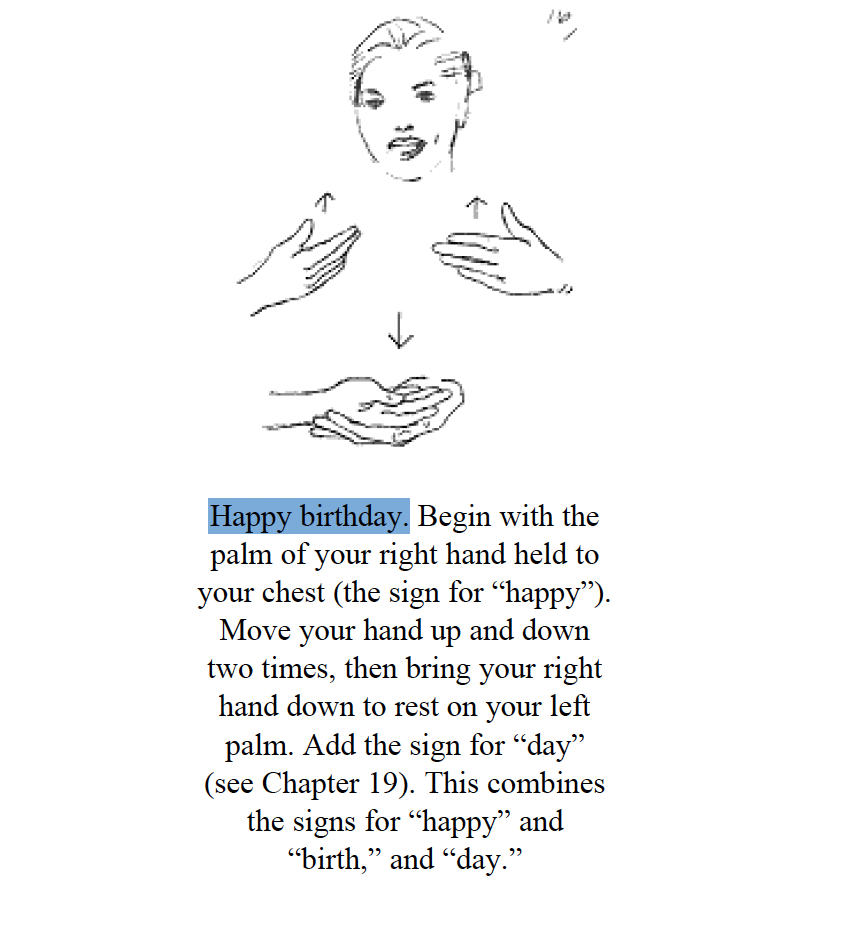

In [18]:
response = model.generate_content(
    'How can I show surprised emotion in american sign language?'
    'Explain concisely in step-by-step fashion. Add all the steps here.'
    'Do not point to any references.'
    )
display(Markdown(response.text))

1.  Make the "S" shape with both hands.
2. Place your hands up near your eyes, with your palms facing your head.
3. Quickly flick your index fingers up. 


From our book resource:

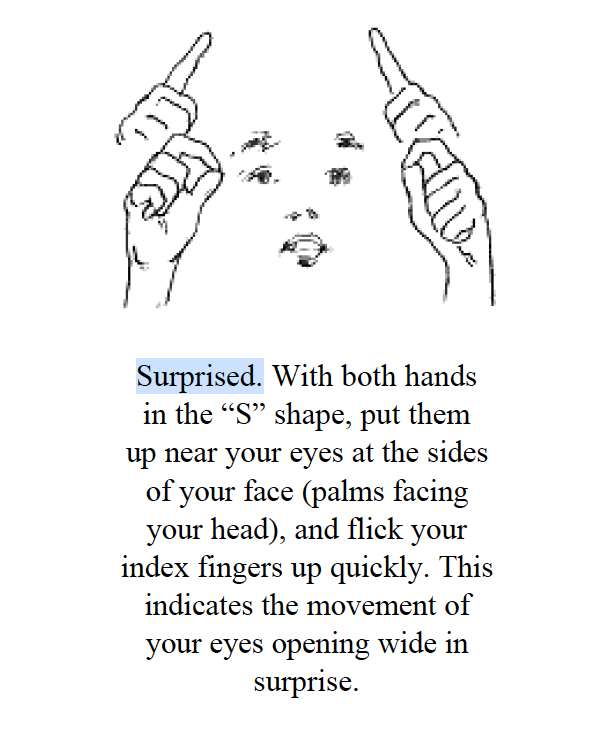

In [ ]:
response = model.generate_content(
    'How can I say "white" in american sign language?'
    'Explain concisely in step-by-step fashion. Add all the steps here.'
    'Do not point to any references.'
    )
display(Markdown(response.text))

Here's how you can sign "white" in American Sign Language:

1.  Form a "5" handshape with your right hand.
2.  Place your thumb and fingertips on your chest.
3.  Move your hand outward while closing your thumb and fingertips. 


The model can now accurately provide instruction on ASL based on the provided manual.

## Conclusion

This project demonstrates an innovative approach to addressing language preservation and accessibility challenges through modern AI technology. By successfully implementing the Gemini Pro model for Kalasha language translation and ASL instruction generation, we've shown that large language models can be effectively adapted for low-resource languages and sign language interpretation when provided with appropriate context and documentation. The experiments with Kalasha, an endangered language with fewer than 5,000 speakers, and American Sign Language highlight both the technical feasibility and the practical impact of such solutions.

Looking ahead, this work opens several promising avenues for future development. Immediate next steps could include expanding the language resource database, improving translation accuracy through refined prompt engineering, and developing more interactive tools for language learning. The methodologies developed here can serve as a template for similar initiatives with other endangered languages and sign languages, contributing to the broader goal of preserving linguistic diversity and enhancing accessibility in our increasingly digital world. While there are still challenges to address, particularly in validation and scalability, this project represents a significant step toward making language technology more inclusive and culturally sensitive.

## References and resources

* Kalasha Texts with Introductory Grammar: https://www.tandfonline.com/doi/pdf/10.1080/03740463.2015.1069049
* Kalasha Dictionary by National Institute of Pakistan Studies: https://ia601702.us.archive.org/25/items/kalasha-dictionary/Kalasha-dictionary.pdf
* Kalasha English and Urdu Dictionary: https://www.indigenouspeople.net/Kalashdictionary.pdf
* The Complete Idiot's Guide to Learning American Sign Language: https://cdn.preterhuman.net/texts/thought_and_writing/language/The%20Complete%20Idiot's%20Guide%20to%20Learning%20American%20Sign%20Language.pdf
* Gemini Context Caching: https://ai.google.dev/gemini-api/docs/caching
